## **Adversarial PCA** - Adversary Behavior

File:  apca_adv_behav.ipynb

Author:  Billy Carson

Date written:  04-11-2021

Last modified:  04-11-2021

> Description: This script uses two synthetic data examples to demonstrate the behavior of the different adversarial Principal Component Analysis (aPCA) variants by plotting reconstruction error and factor predictability as a function of adversary strength.


### **Import modules**

In [1]:
# Import modules
import sys
import numpy as np
from numpy.random import RandomState, SeedSequence
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

# Import aPCA and utilities modules
sys.path.append('..')
from adv_pca import *
from utils import *


### **Function definitions**

In [2]:
# Plot adversary behavior (e.g., reconstruction error, predictability) for increasing adversary strength
def plot_adv_behav(data_dict, n_components, mu_lo=0.0, mu_hi=10.0, mu_step=0.1, suptitle=None, random_state=None):
    """
    Description
    -----------
    Plot adversary behavior - reconstruction error and predictability of scores as a function of adversary strenth.
    
    Parameters
    ----------
    data_dict : dict; dictionary of training and test data and labels
    n_components : int; number of components
    mu_lo : float; lowest adversary strength value
    mu_hi : float; highest adversary strength value
    mu_step : float; step value for adversary strength
    suptitle : str; plot title
    random_state : int; random state to use as random number generator seed
    
    Returns
    -------
    N/A
    """
    
    # Extract data from dictionary
    X_train = data_dict['X_train']
    X_test = data_dict['X_test']
    Y_train = data_dict['Y_train']
    Y_test = data_dict['Y_test']
    labels_train = data_dict['labels_train']
    labels_test = data_dict['labels_test']

    # Create list of mu values
    mu_list = list(np.arange(mu_lo, mu_hi + mu_step, mu_step))
    
    # Initialize logistic regression model with no penalty
    lr_model = LogisticRegression(penalty='none', fit_intercept=True, random_state=random_state, max_iter=1000)

    # Initialize primary data reconstruction error lists
    X_recon_err_lpca_list = []
    X_recon_err_epca_list = []
    X_recon_err_jpca_list = []

    # Initialize concomitant data reconstruction error lists
    Y_recon_err_lpca_list = []
    Y_recon_err_epca_list = []
    Y_recon_err_jpca_list = []

    # Initialize AUC lists
    auc_lpca_list = []
    auc_epca_list = []
    auc_jpca_list = []

    # Iterate over adversary strength values
    for mu in mu_list:
        # Instantiate aPCA models
        l_apca = LocalAdvPCA(n_components=n_components, mu=mu)
        e_apca = EncodedAdvPCA(n_components=n_components, mu=mu)
        j_apca = JointAdvPCA(n_components=n_components, mu=mu)

        # Fit aPCA models to training data, get scores
        S_lapca_train = l_apca.fit_transform(X=X_train, Y=Y_train)
        S_eapca_train = e_apca.fit_transform(X=X_train, Y=Y_train)
        S_japca_train = j_apca.fit_transform(X=X_train, Y=Y_train)

        # Get scores from test data
        S_lapca_test = l_apca.transform(X=X_test, Y=Y_test)
        S_eapca_test = e_apca.transform(X=X_test, Y=Y_test)
        S_japca_test = j_apca.transform(X=X_test, Y=Y_test)

        # Fit models and get prediction probabilities for each adversary
        lr_model.fit(S_lapca_train, labels_train)
        labels_prob_lpca = lr_model.predict_proba(S_lapca_test)[:, 1]
        lr_model.fit(S_eapca_train, labels_train)
        labels_prob_epca = lr_model.predict_proba(S_eapca_test)[:, 1]
        lr_model.fit(S_japca_train, labels_train)
        labels_prob_jpca = lr_model.predict_proba(S_japca_test)[:, 1]

        # Calculate AUC from test set predictions
        auc_lpca = roc_auc_score(y_true=labels_test, y_score=labels_prob_lpca)
        auc_epca = roc_auc_score(y_true=labels_test, y_score=labels_prob_epca)
        auc_jpca = roc_auc_score(y_true=labels_test, y_score=labels_prob_jpca)

        # Append AUC values to adversary-specific lists
        auc_epca_list.append(auc_epca)
        auc_lpca_list.append(auc_lpca)
        auc_jpca_list.append(auc_jpca)

        X_recon_lapca, Y_recon_lapca = l_apca.reconstruct(X=X_test, Y=Y_test)
        X_recon_eapca, Y_recon_eapca = e_apca.reconstruct(X=X_test, Y=Y_test)
        X_recon_japca, Y_recon_japca = j_apca.reconstruct(X=X_test, Y=Y_test)

        X_recon_err_lpca = np.mean((X_test - X_recon_lapca) ** 2)
        X_recon_err_epca = np.mean((X_test - X_recon_eapca) ** 2)
        X_recon_err_jpca = np.mean((X_test - X_recon_japca) ** 2)

        Y_recon_err_lpca = np.mean((Y_test - Y_recon_lapca) ** 2)
        Y_recon_err_epca = np.mean((Y_test - Y_recon_eapca) ** 2)
        Y_recon_err_jpca = np.mean((Y_test - Y_recon_japca) ** 2)

        # Append primary data reconstruction errors to adversary-specific lists
        X_recon_err_lpca_list.append(X_recon_err_lpca)
        X_recon_err_epca_list.append(X_recon_err_epca)
        X_recon_err_jpca_list.append(X_recon_err_jpca)

        # Append concomitant data reconstruction errors to adversary-specific lists
        Y_recon_err_lpca_list.append(Y_recon_err_lpca)
        Y_recon_err_epca_list.append(Y_recon_err_epca)
        Y_recon_err_jpca_list.append(Y_recon_err_jpca)
    
    # Initialize figure
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(9, 8))

    # Plot primary data reconstruction error
    ax[0].plot(mu_list, X_recon_err_lpca_list, c='b', linestyle='-', linewidth=1.0, alpha=1.0, label='local adv.')
    ax[0].plot(mu_list, X_recon_err_epca_list, c='g', linestyle='-', linewidth=1.0, alpha=0.9, label='encoded adv.')
    ax[0].plot(mu_list, X_recon_err_jpca_list, c='r', linestyle='--', linewidth=3.0, alpha=0.4, label='joint adv.')
    ax[0].set_title('Reconstruction Error - Primary Data Test Set')
    ax[0].set_ylabel('Reconstruction Error')
    ax[0].grid(alpha=0.3)
    ax[0].set_axisbelow(True)
    ax[0].legend(loc='lower right')
    
    # Plot primary data reconstruction error
    ax[1].plot(mu_list, Y_recon_err_lpca_list, c='b', linestyle='-', linewidth=1.0, alpha=1.0, label='local adv.')
    ax[1].plot(mu_list, Y_recon_err_epca_list, c='g', linestyle='-', linewidth=1.0, alpha=0.9, label='encoded adv.')
    ax[1].plot(mu_list, Y_recon_err_jpca_list, c='r', linestyle='--', linewidth=3.0, alpha=0.4, label='joint adv.')
    ax[1].set_title('Reconstruction Error - Concomitant Data Test Set')
    ax[1].set_ylabel('Reconstruction Error')
    ax[1].grid(alpha=0.3)
    ax[1].set_axisbelow(True)
    ax[1].legend(loc='lower right')

    # Plot AUC (predicting between class 1 and 2) as a function of adversary strength
    ax[2].plot(mu_list, auc_lpca_list, c='b', linestyle='-', linewidth=1.0, alpha=1.0, label='local adv.')
    ax[2].plot(mu_list, auc_epca_list, c='g', linestyle='-', linewidth=1.0, alpha=0.9, label='encoded adv.')
    ax[2].plot(mu_list, auc_jpca_list, c='r', linestyle='--', linewidth=3.0, alpha=0.4, label='joint adv.')
    ax[2].set_title('AUC - Test Set')
    ax[2].set_xlabel('Adversary Strength')
    ax[2].set_ylabel('AUC')
    ax[2].grid(alpha=0.3)
    ax[2].set_axisbelow(True)
    ax[2].legend(loc='lower right')
    
    # Plot title
    if suptitle is not None:
        fig.set_suptitle(suptitle)

    # Adjust space between subplots and display plot
    fig.subplots_adjust(hspace=0.35)
    plt.show()
    
    # Return none
    return None


### **Plot and split function parameters**

In [3]:
# Define plot function parameters
mu_lo = 0.0
mu_hi = 10.0
mu_step = 0.02
random_state = 4

# Define train/test split function parameters
test_size = 0.3
shuffle = True


## **Synthetic data example 1** - Concomitant data independent of class

### **Load synthetic data**

In [4]:
# Load synthetic data with concomitant data generated independent of class
X = np.load('synthetic_data/X_synth_1.npy')
Y = np.load('synthetic_data/Y_synth_1.npy')
labels = np.load('synthetic_data/labels_synth_1.npy')


### **Preprocess data** - Scale, split, and prepare for visualization

In [5]:
# Scale data
X_scaled = scale(X.copy())
Y_scaled = scale(Y.copy())

# Split data into training and test splits
X_train, X_test, Y_train, Y_test, labels_train, labels_test = train_test_split(X_scaled, Y_scaled, labels, test_size=test_size,
                                                                               shuffle=shuffle, random_state=random_state)

# Assign data to dictionary
data_dict = {}
data_dict['X_train'] = X_train
data_dict['X_test'] = X_test
data_dict['Y_train'] = Y_train
data_dict['Y_test'] = Y_test
data_dict['labels_train'] = labels_train
data_dict['labels_test'] = labels_test


### **Plot adversary behavior** - 1 component

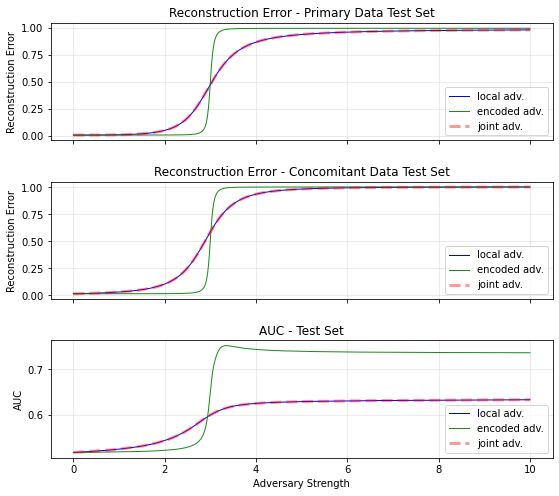

In [6]:
# Plot aPCA variant behavior - 1 component
plot_adv_behav(data_dict=data_dict, n_components=1, mu_lo=mu_lo, mu_hi=mu_hi, mu_step=mu_step, random_state=random_state)


### **Plot adversary behavior** - 2 components

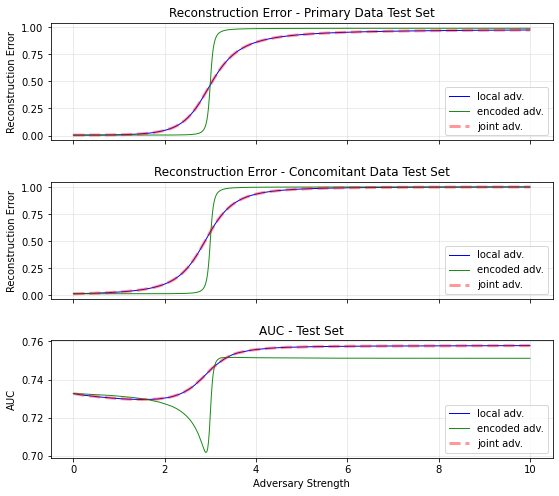

In [7]:
# Plot aPCA variant behavior - 2 component
plot_adv_behav(data_dict=data_dict, n_components=2, mu_lo=mu_lo, mu_hi=mu_hi, mu_step=mu_step, random_state=random_state)


## **Synthetic data example 2** - Concomitant data *dependent* on class

### **Load synthetic data**

In [8]:
# Load synthetic data with concomitant data generated independent of class
X = np.load('synthetic_data/X_synth_2.npy')
Y = np.load('synthetic_data/Y_synth_2.npy')
labels = np.load('synthetic_data/labels_synth_2.npy')


### **Preprocess data** - Scale, split, and prepare for visualization

In [9]:
# Scale data
X_scaled = scale(X.copy())
Y_scaled = scale(Y.copy())

# Split data into training and test splits
X_train, X_test, Y_train, Y_test, labels_train, labels_test = train_test_split(X_scaled, Y_scaled, labels, test_size=test_size,
                                                                               shuffle=shuffle, random_state=random_state)

# Assign data to dictionary
data_dict = {}
data_dict['X_train'] = X_train
data_dict['X_test'] = X_test
data_dict['Y_train'] = Y_train
data_dict['Y_test'] = Y_test
data_dict['labels_train'] = labels_train
data_dict['labels_test'] = labels_test


### **Plot adversary behavior** - 1 component

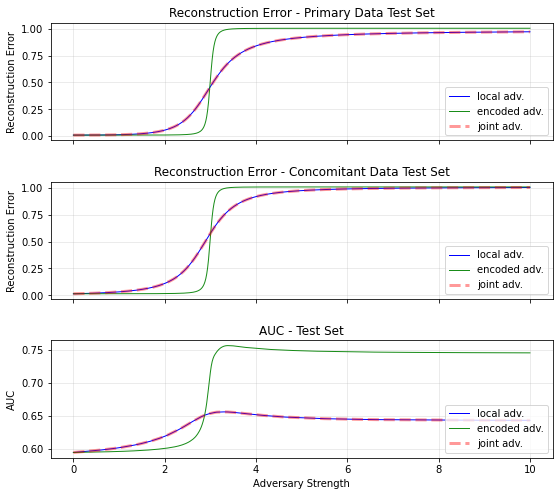

In [10]:
# Plot aPCA variant behavior - 1 component
plot_adv_behav(data_dict=data_dict, n_components=1, mu_lo=mu_lo, mu_hi=mu_hi, mu_step=mu_step, random_state=random_state)


### **Plot adversary behavior** - 2 components

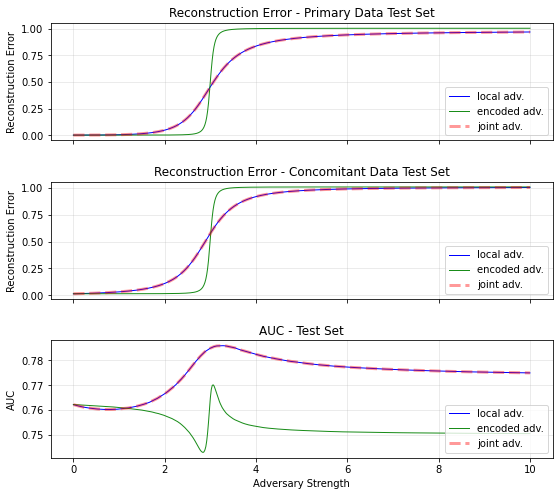

In [11]:
# Plot aPCA variant behavior - 2 component
plot_adv_behav(data_dict=data_dict, n_components=2, mu_lo=mu_lo, mu_hi=mu_hi, mu_step=mu_step, random_state=random_state)
